Complete the exercises below For **Assignment #4**.

Use **Markdown** cells for the non-code answers.

In this assignment we will work with the data underlying the *FiveThirtyEight* article ["Higher Rates Of Hate Crimes Are Tied To Income Inequality"](https://fivethirtyeight.com/features/higher-rates-of-hate-crimes-are-tied-to-income-inequality/).

Load the `tidymodels`, `readr`, and `moderndive` packages in the cell below.

In [21]:
library('tidymodels')
library('readr')
library('moderndive')

We can read the data from a **CSV file** at the following URL: [http://bit.ly/2ItxYg3](http://bit.ly/2ItxYg3).

Use the `read_csv` function to read the data into our R session. Call the new table `hate_crimes`.

In [45]:
hate_crimes = read_csv("http://bit.ly/2ItxYg3")
head(hate_crimes)

Rows: 51 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): state, median_house_inc, trump_support, unemployment, urbanization
dbl (4): share_pop_metro, hs, hate_crimes, income

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


state,median_house_inc,share_pop_metro,hs,hate_crimes,trump_support,unemployment,urbanization,income
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
New Mexico,low,0.69,83,0.295,low,high,low,46686
Maine,low,0.54,90,0.616,low,low,low,51710
New York,low,0.94,85,0.351,low,low,high,54310
Illinois,low,0.90,86,0.195,low,high,high,54916
Delaware,high,0.90,87,0.323,low,low,high,57522
Rhode Island,high,1.00,85,0.095,low,high,high,58633


Next, let’s add the high-school degree variable into the mix by creating a scatterplot showing:

- Income on the y-axis (this is the `income` variable)
- Percent of adults 25 or older with a high school degree on the x-axis (this is the `hs` variable)
- The points colored by level of urbanization in a region (this is the variable `urbanization`)


**In addition, add a line of best fit (regression line) for each level of the variable urbanization (one for “low”, one for “high”).**

*Add the regression lines to the plot using the `geom_parallel_slopes` function from the `moderndive` package. This function will draw the regression lines based on fitting a regression model with parallel slopes (i.e., with no interaction between `hs` and `urbanization`).*

Warning message in geom_parallel_slopes(model = model):
“Ignoring unknown parameters: `model`”
Warning message:
“Removed 3 rows containing non-finite outside the scale range
(`stat_parallel_slopes()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


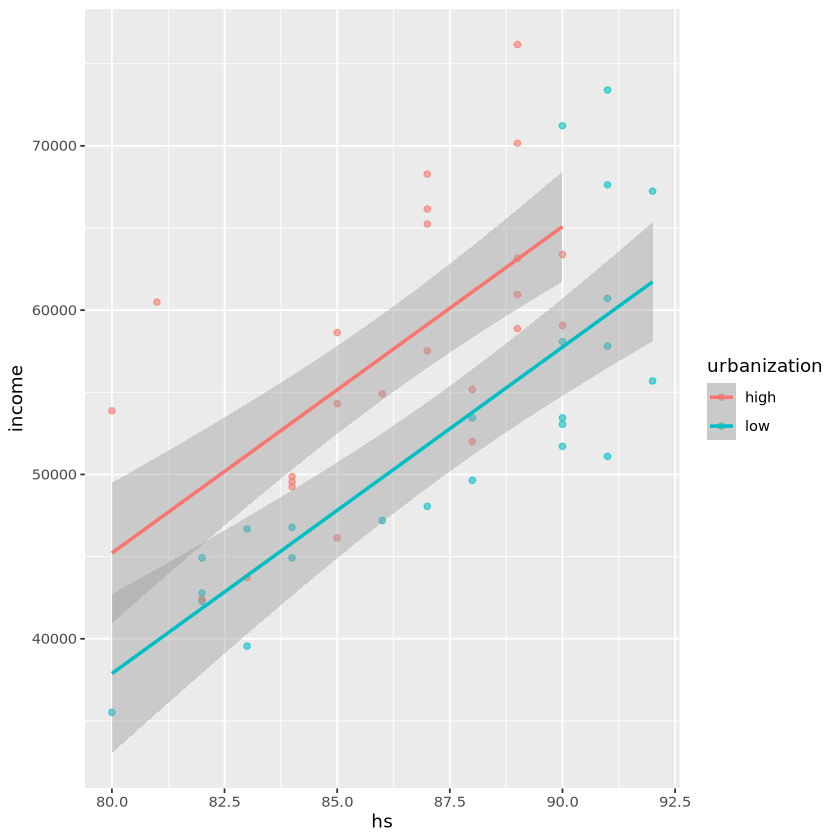

In [53]:
ggplot(hate_crimes, aes(x = hs, y = income, color = urbanization)) +
  geom_point(alpha = 0.6) +
  geom_parallel_slopes(model = model)

❓Which regression line (high urbanization or low urbanization) appears to have the larger intercept?

**Answer:** 

High urbanization has the larger intercept noted by its locatoin on the graph. 

Now let’s create a second scatterplot using the same variables, but this time draw the regression lines using `geom_smooth(method = "lm")`, which will allow for separate, non-parallel slopes for each urbanization group. 

**Code your scatter plot in the cell below.**

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 3 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


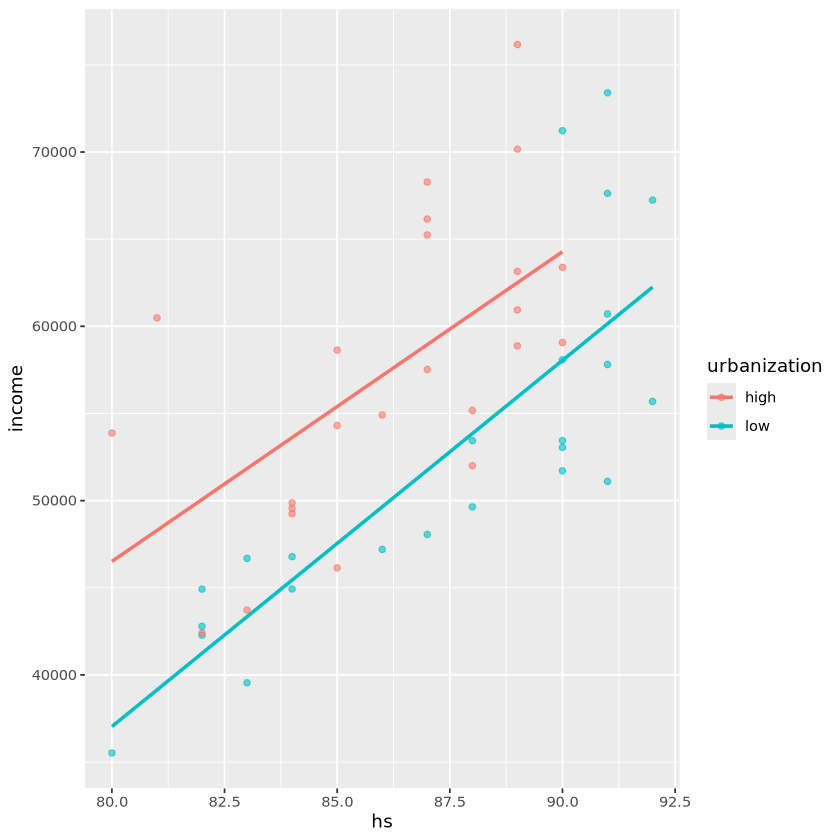

In [52]:
ggplot(hate_crimes, aes(x = hs, y = income, color = urbanization)) +
  geom_point(alpha = 0.6) +
  geom_smooth(method = "lm", se = FALSE) 

❓Based on visually comparing the two models shown above, do you think it would be best to run a “parallel slopes” model (i.e. a model that estimates one shared slope for the two levels of urbanization), or a more complex “interaction model” (i.e. a model that estimates a separate slope for the two levels of urbanization)?

**Answer:**

I would see having the independent slopes to be more advantageous because I would imagine there's a more complete story to be told looking at the variables separately. 

Fit the following two regression models that examine the relationship between household `income` (as response variable), and high-school education (`hs`) and `urbanization` as explanatory variables:

1. A parallel slopes model (i.e., no interaction between `hs` and `urbanization`). ❗️Save the data recipe and model under the variables `ps_rec` and `ps_mod`, respectively. 
1. A non-parallel slopes model (i.e., allow `hs` and `urbanization` to interact in your model). ❗️Save the data recipe and model under the variable: `nps_rec` and `nps_mod`, respectively.

**Code you your models in the cell below.**

In [25]:
# parallel slopes model

ps_rec = recipe(income ~ hs + urbanization, data = hate_crimes) |> 
    step_naomit(everything()) |>   # remove missing values
    step_dummy(urbanization) |>    # dummy encode the urbanization variable
    prep()                         # run the recipe on the training data provided

mod = linear_reg() |> set_engine('lm')

ps_mod = mod |> fit(income ~ ., juice(ps_rec))

ps_mod

parsnip model object


Call:
stats::lm(formula = income ~ ., data = data)

Coefficients:
     (Intercept)                hs  urbanization_low  
         -113725              1987             -7333  


In [39]:
nps_rec = recipe(income ~ hs + urbanization, data = hate_crimes) |> 
    step_naomit(everything()) |>             # remove missing values
    step_dummy(urbanization) |>              # dummy encode urbanization
    step_interact(~ hs:starts_with("urbanization")) |>  # create interaction term
    prep()

mod = linear_reg() |> set_engine("lm")

nps_mod = mod |> fit(income ~ ., juice(nps_rec))

nps_mod

parsnip model object


Call:
stats::lm(formula = income ~ ., data = data)

Coefficients:
          (Intercept)                     hs       urbanization_low  
               -95647                   1777                 -35394  
hs_x_urbanization_low  
                  324  


The following code creates a table of your model predictions over the training data. Calculate the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) (R<sup>2</sup>) for each model:

```r
rbind(
    augment(ps_mod, juice(ps_rec)) |> select(income, .pred, .resid) |> mutate(model = "parallel_slopes"),
    augment(nps_mod, juice(nps_rec)) |> select(income, .pred, .resid) |> mutate(model = "interaction")
)
```

1. Group rows by the `model` variable (use the `group_by` function).
1. Calculate the variance of income over the variance of your predictions for each model using the "grouped" data from the step above (use `summarize(r_squared = var(.pred) / var(income))`).

In [40]:
library('dplyr')
library('broom')

results = rbind(
    augment(ps_mod, juice(ps_rec)) |> 
        select(income, .pred, .resid) |> 
        mutate(model = "parallel_slopes"),
    
    augment(nps_mod, juice(nps_rec)) |> 
        select(income, .pred, .resid) |> 
        mutate(model = "interaction"))

r2_table = results |>
    group_by(model) |>
    summarize(r_squared = var(.pred) / var(income))

r2_table

model,r_squared
<chr>,<dbl>
interaction,0.5746731
parallel_slopes,0.5716112


🎶 Note: you can also use the `glance` function with a model as input to find the coefficient of determination.

In [41]:
glance(ps_mod)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.5716112,0.5525717,6325.667,30.02238,5.204241e-09,2,-486.6739,981.3479,988.8327,1800633086,45,48


In [42]:
glance(nps_mod)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.5746731,0.5456735,6374.244,19.81661,2.814509e-08,3,-486.5018,983.0035,992.3595,1787763166,44,48


❓Compare the adjusted proportion of variance accounted for in each model. Based on this comparison, which model do you prefer? Why? 

**Answer:** 

Because the Parallel slopes model has an adjusted R^2 of .5526 and the non-parallel slopes model has an adjusted R^2 of .5456 I would prefer the parallel model because it technically provides a more accurate representation of the relationship. 

❓Using your preferred model, based on your regression model parameters (and the data visualizations), is `income` greater in states that have lower or higher levels of `urbanization`? By how much?

**Hint:** use the `tidy` function with your model as input to access the parameters in a nice table.

**Answer:** Income would appear to be greater in states with higher levels of urbanization by about $7,333.33 on average. 

In [44]:
library('broom')

tidy(ps_mod)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-113725.193,23552.9187,-4.828497,1.624694e-05
hs,1986.794,272.9303,7.279490,3.930730e-09
urbanization_low,-7333.326,1857.6592,-3.947616,2.744526e-04


❓For every one percentage point increase of high-school educated adults in a state (`hs` variable), what is the associated average increase in `income`?

**Answer:** On average each percentage point increase leads to an income increase of $1,986.79